# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [1]:
# Our goal here is to determine which variables (e.g. make, model, year, mileage, etc.) have the most significant impact on the sale price of the car.

In [2]:
# We also want to build a predictive model to estimate the price of cars based on the values of the variables

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [3]:
# I would first ensure that the data does not have any issues like null values. Depending on the number of null values in a column, I would consider either dropping the handful of roles, or perhaps drop the entire column

In [4]:
# I would also look at the data types I am working with, and make adjustments such as OneHotEncoding for categorical data or converting dates to datetime objects.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [85]:
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split

In [86]:
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [87]:
vehicles['VIN'].value_counts().sort_values()
# there seem to be a lot of duplicate VINs. will handle this by dropping the duplicate rows (and just keep one of them)

VIN
2G1FP22P1T2123488      1
5TEUU42N69Z626493      1
5TFCZ5AN1JX164943      1
5TEHN72N44Z330817      1
1FTRF12W07NA69815      1
                    ... 
1GCHTCE37G1186784    214
5TFTX4CN3EX042751    227
1FTER1EH1LLA36301    231
3C6JR6DT3KG560649    235
1FMJU1JT1HEA52352    261
Name: count, Length: 118246, dtype: int64

In [88]:
# Drop duplicates based on VIN, and drop VIN column
df_cleaned = vehicles.drop_duplicates(subset='VIN', keep='first')
df_cleaned.drop(columns=['VIN'], inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118247 entries, 0 to 426833
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            118247 non-null  int64  
 1   region        118247 non-null  object 
 2   price         118247 non-null  int64  
 3   year          117653 non-null  float64
 4   manufacturer  115179 non-null  object 
 5   model         117542 non-null  object 
 6   condition     61082 non-null   object 
 7   cylinders     70266 non-null   object 
 8   fuel          116608 non-null  object 
 9   odometer      116671 non-null  float64
 10  title_status  114608 non-null  object 
 11  transmission  117010 non-null  object 
 12  drive         90898 non-null   object 
 13  size          30310 non-null   object 
 14  type          102062 non-null  object 
 15  paint_color   87564 non-null   object 
 16  state         118247 non-null  object 
dtypes: float64(2), int64(2), object(13)
memory usage: 16.

In [89]:
# dropping size column since there are too many missing values
df_cleaned.drop(columns=['size'], inplace=True)

In [90]:
# there are only a handful of missing year and manufacturer values, so I am dropping those rows
df_cleaned.dropna(subset=['year'], inplace=True)
df_cleaned.dropna(subset=['manufacturer'], inplace=True)

In [91]:
df_cleaned['fuel'].value_counts()

fuel
gas         98429
other        7754
diesel       5453
hybrid       1544
electric      505
Name: count, dtype: int64

In [92]:
# compared to the number of gas-burning cars, we don't have much data on the other fuel types. Models do well on data similar to which they were trained for, so I will be dropping the non-gas rows.
df_cleaned = df_cleaned[df_cleaned['fuel'] == 'gas']

In [93]:
df_cleaned['title_status'].value_counts()

title_status
clean         93772
rebuilt        1264
salvage         481
lien            170
missing          31
parts only        8
Name: count, dtype: int64

In [94]:
# for similar reasons as fuel, I will only be keeping the rows where the title is clean
df_cleaned = df_cleaned[df_cleaned['title_status'] == 'clean']

In [95]:
# each car manufacturer has tons of different models that they sell. dropping this column since I don't want to have such a granular view of categorical data
df_cleaned.drop(columns=['model'], inplace=True)

In [96]:
df_cleaned['condition'].value_counts()

condition
excellent    26419
good         17313
like new      3407
fair           589
new            287
salvage         18
Name: count, dtype: int64

In [97]:
# condition has a lot of missing values. for these missing values, I will fill them in with 'unknown'
df_cleaned['condition'].fillna('unknown', inplace=True)

# additionally, 'salvage', 'fair', and 'new' are not common conditions in the dataset, and wouldn't be too useful for our modeling. I will drop 'salvage' and 'fair', but group new into the 'like new' category since these should be similar.
df_cleaned['condition'] = df_cleaned['condition'].replace({'new': 'like new'})
df_cleaned = df_cleaned[~df_cleaned['condition'].isin(['salvage', 'fair'])]

# since the condition of a car has some sort of inherent order/ranking to them, let's replace 'like new' with 5, 'excellent' with 4, 'good' with 3, and 'unknown' with 1.
condition_mapping = {'like new': 5, 'excellent': 4, 'good': 3, 'unknown': 1}
df_cleaned['condition'] = df_cleaned['condition'].map(condition_mapping)

In [98]:
df_cleaned['cylinders'].value_counts()

cylinders
4 cylinders     21660
6 cylinders     21044
8 cylinders     12425
5 cylinders       453
10 cylinders      267
3 cylinders       168
other             135
12 cylinders       28
Name: count, dtype: int64

In [99]:
# Combine uncommon cylinder values into 'other'
rare_cylinders = ['5 cylinders', '10 cylinders', '3 cylinders', '12 cylinders']
df_cleaned['cylinders'] = df_cleaned['cylinders'].replace(rare_cylinders, 'other')
# additionally, since the column has a large number of null values, let's put them in a new category called 'unknown' to prevent introducing bias
df_cleaned['cylinders'].fillna('unknown', inplace=True)

In [100]:
# odometer has only a handful of missing values, so I will fill the missing data with the median odometer value
df_cleaned['odometer'].fillna(df_cleaned['odometer'].median(), inplace=True)

In [101]:
# since the vast majority of rows have 'automatic' for the transmission type, I will fill the missing data with this value
df_cleaned['transmission'].fillna(df_cleaned['transmission'].mode()[0], inplace=True)

In [102]:
# the drivetrain has many missing values, will handle this using an 'unknown' value
df_cleaned['drive'].fillna('unknown', inplace=True)

In [103]:
df_cleaned['type'].value_counts()

type
sedan          24079
SUV            23810
pickup          6477
truck           6374
other           4151
coupe           3725
wagon           3276
hatchback       3165
van             1952
convertible     1666
mini-van        1353
offroad           58
bus               45
Name: count, dtype: int64

In [104]:
# since there are many types, I will combine them into categories that I think fit together logically
df_cleaned['type'] = df_cleaned['type'].replace({
    'pickup': 'truck',
    'coupe': 'sport',
    'convertible': 'sport',
    'wagon': '3-row',
    'van': '3-row',
    'mini-van': '3-row',
    'hatchback': 'other',
    'offroad': 'other',
    'bus': 'other'
})

# also, toss any null values into the 'other' category
df_cleaned['type'].fillna('other', inplace=True)

In [105]:
# dropping region, paint_color, and state columns
df_cleaned.drop(columns=['region','paint_color','state'], inplace=True)

In [106]:
df_cleaned['price'].describe()

count    9.316500e+04
mean     1.701986e+04
std      4.053337e+05
min      0.000000e+00
25%      5.999000e+03
50%      1.290000e+04
75%      2.199900e+04
max      1.234568e+08
Name: price, dtype: float64

In [107]:
# seeing as there are extremely high and low values in 'price', I will be first dropping all rows where the price is $0, since this doesn't make sense.
df_cleaned = df_cleaned[df_cleaned['price'] > 0]

In [108]:
# next, I will place the price on a logarithmic scale
df_cleaned['log_price'] = np.log1p(df_cleaned['price'])

In [109]:
# now I will also clean any prices that are outliers on the logarithmic scale.

Q1 = df_cleaned['log_price'].quantile(0.25)
Q3 = df_cleaned['log_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df_cleaned[(df_cleaned['log_price'] >= lower_bound) & (df_cleaned['log_price'] <= upper_bound)]
df_cleaned.drop(columns=['log_price'], inplace=True)
df_cleaned['price'].describe()

count     80015.000000
mean      18030.738499
std       12557.862873
min        1575.000000
25%        8888.000000
50%       14991.000000
75%       24000.000000
max      122995.000000
Name: price, dtype: float64

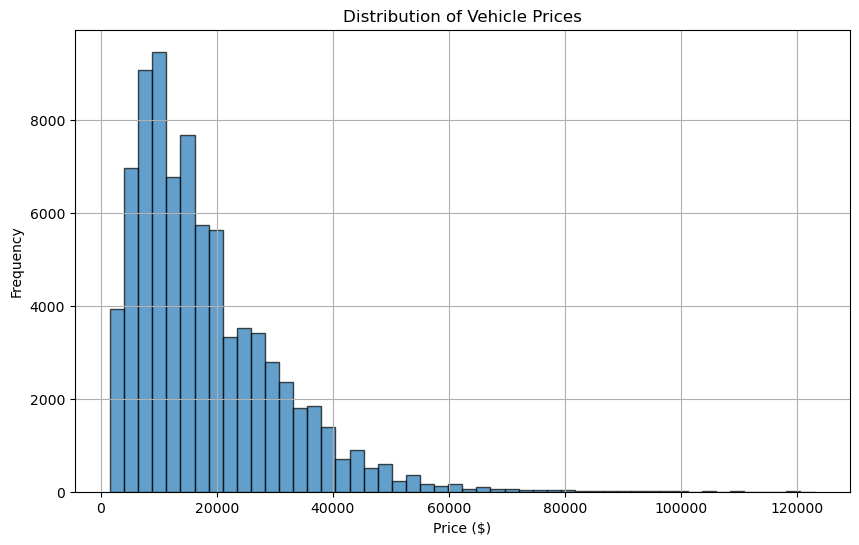

In [110]:
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['price'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Vehicle Prices')
plt.grid(True)
plt.show()

# looking much better!

In [111]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80015 entries, 27 to 426833
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            80015 non-null  int64  
 1   price         80015 non-null  int64  
 2   year          80015 non-null  float64
 3   manufacturer  80015 non-null  object 
 4   condition     80015 non-null  int64  
 5   cylinders     80015 non-null  object 
 6   fuel          80015 non-null  object 
 7   odometer      80015 non-null  float64
 8   title_status  80015 non-null  object 
 9   transmission  80015 non-null  object 
 10  drive         80015 non-null  object 
 11  type          80015 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 7.9+ MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [112]:
X = df_cleaned.drop(columns=['price'])
y = df_cleaned['price']

In [113]:
numeric_features = ['year', 'odometer']
categorical_features = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using make_column_transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)

In [114]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
ridge = Ridge()
sfs = SequentialFeatureSelector(ridge, n_features_to_select=10)

In [116]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', sfs),
    ('regressor', ridge)
    ])

In [117]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type'])])),
                ('feature_selection',
                 SequentialFeatureSelector(estimator=Ridge(),
                                           n_features_to_select=10)),
                ('regressor', Ridge())])

In [118]:
# Define the parameter grid for GridSearchCV
param_grid = { 'regressor__alpha': [0.1, 1.0, 10.0, 100.0] }

In [119]:
transformed_pipeline = TransformedTargetRegressor(
    regressor=GridSearchCV(pipeline, param_grid, cv=2, n_jobs=-1, verbose=3),
    func=np.log1p,
    inverse_func=np.expm1
    )

In [120]:
transformed_pipeline

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=2,
                                                  estimator=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('pipeline',
                                                                                                              Pipeline(steps=[('scaler',
                                                                                                                               StandardScaler())]),
                                                                                                              ['year',
                                                                                                               'odometer']),
                                                                                                             ('onehotencoder',
                                                                                                              OneHotEncoder(handle_unknown='ignore'),
                                                                                                              ['manufacturer',
                                                                                                               'condition',
                                                                                                               'cylinders',
                                                                                                               'fuel',
                                                                                                               'title_status',
                                                                                                               'transmission',
                                                                                                               'drive',
                                                                                                               'type'])])),
                                                                            ('feature_selection',
                                                                             SequentialFeatureSelector(estimator=Ridge(),
                                                                                                       n_features_to_select=10)),
                                                                            ('regressor',
                                                                             Ridge())]),
                                                  n_jobs=-1,
                                                  param_grid={'regressor__alpha': [0.1,
                                                                                   1.0,
                                                                                   10.0,
                                                                                   100.0]},
                                                  verbose=3))

In [121]:
transformed_pipeline.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=GridSearchCV(cv=2,
                                                  estimator=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('pipeline',
                                                                                                              Pipeline(steps=[('scaler',
                                                                                                                               StandardScaler())]),
                                                                                                              ['year',
                                                                                                               'odometer']),
                                                                                                             ('onehotencoder',
                                                                                                              OneHotEncoder(handle_unknown='ignore'),
                                                                                                              ['manufacturer',
                                                                                                               'condition',
                                                                                                               'cylinders',
                                                                                                               'fuel',
                                                                                                               'title_status',
                                                                                                               'transmission',
                                                                                                               'drive',
                                                                                                               'type'])])),
                                                                            ('feature_selection',
                                                                             SequentialFeatureSelector(estimator=Ridge(),
                                                                                                       n_features_to_select=10)),
                                                                            ('regressor',
                                                                             Ridge())]),
                                                  n_jobs=-1,
                                                  param_grid={'regressor__alpha': [0.1,
                                                                                   1.0,
                                                                                   10.0,
                                                                                   100.0]},
                                                  verbose=3))

In [122]:
y_pred = transformed_pipeline.predict(X_test)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [123]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("mae:", mae)
print("mse:", mse)

mae: 5325.601815693581
mse: 72832524.04387224


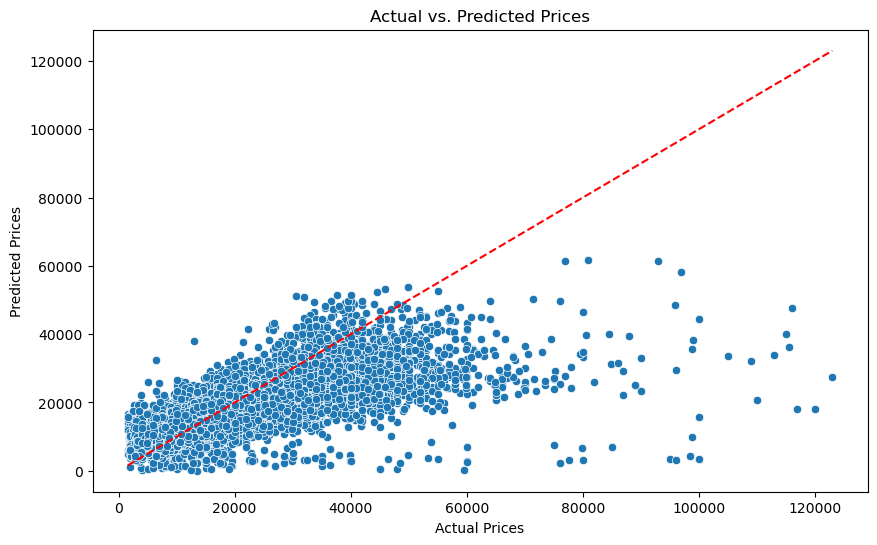

In [124]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.show()

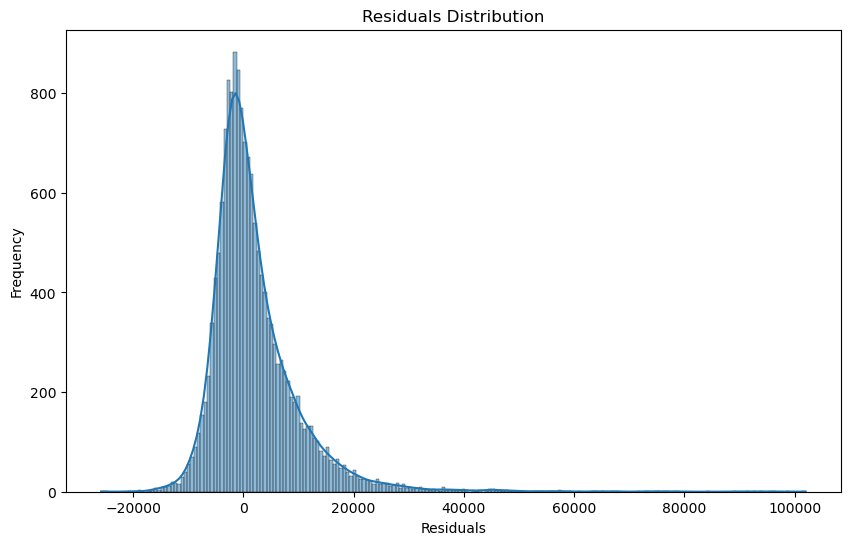

In [125]:
# Residual plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

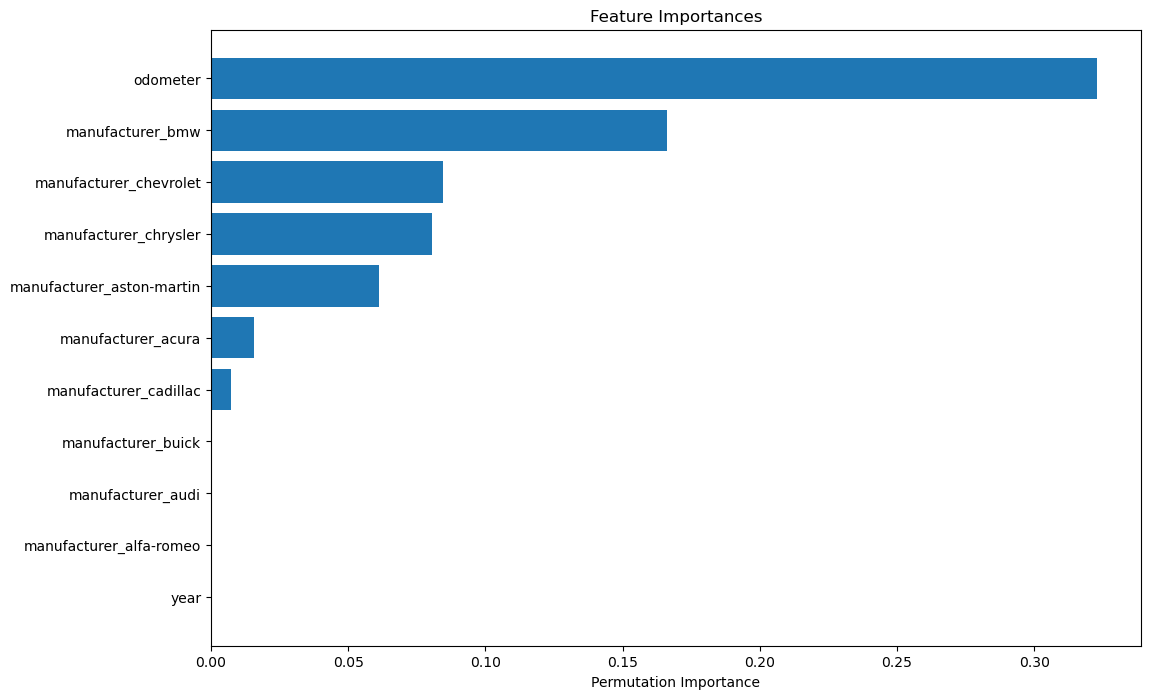

In [140]:
# Compute permutation importance
result = permutation_importance(transformed_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Extract feature importance
feature_importances = result.importances_mean

# Get feature names (from preprocessor)
feature_names = numeric_features + list(transformed_pipeline.regressor_.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, feature_importances[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

#### Report for used car dealers:

After cleaning up the data provided, we created a model to best estimate the sale price of the car based on various aspects such as the year, odometer, manufacturer, etc.

Now that we have performed our analysis, it appears that the miles on the odometer is the single largest contributing factor to the sale price.

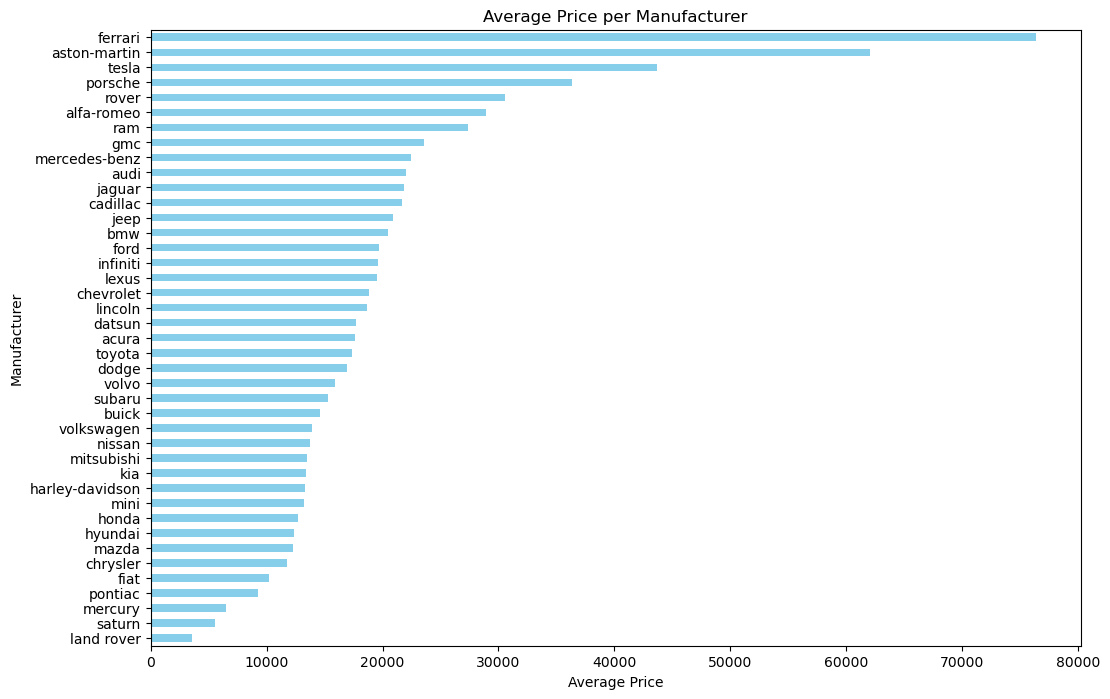

In [143]:
average_price_per_manufacturer = df_cleaned.groupby('manufacturer')['price'].mean().sort_values()

plt.figure(figsize=(12, 8))
average_price_per_manufacturer.plot(kind='barh', color='skyblue')
plt.xlabel('Average Price')
plt.ylabel('Manufacturer')
plt.title('Average Price per Manufacturer')
plt.show()


The second point of consideration should be the manufacturer of the vehicle, with some manufacturer selling their cars for a higher price than others. See the graph above for the average price by manufacturer.

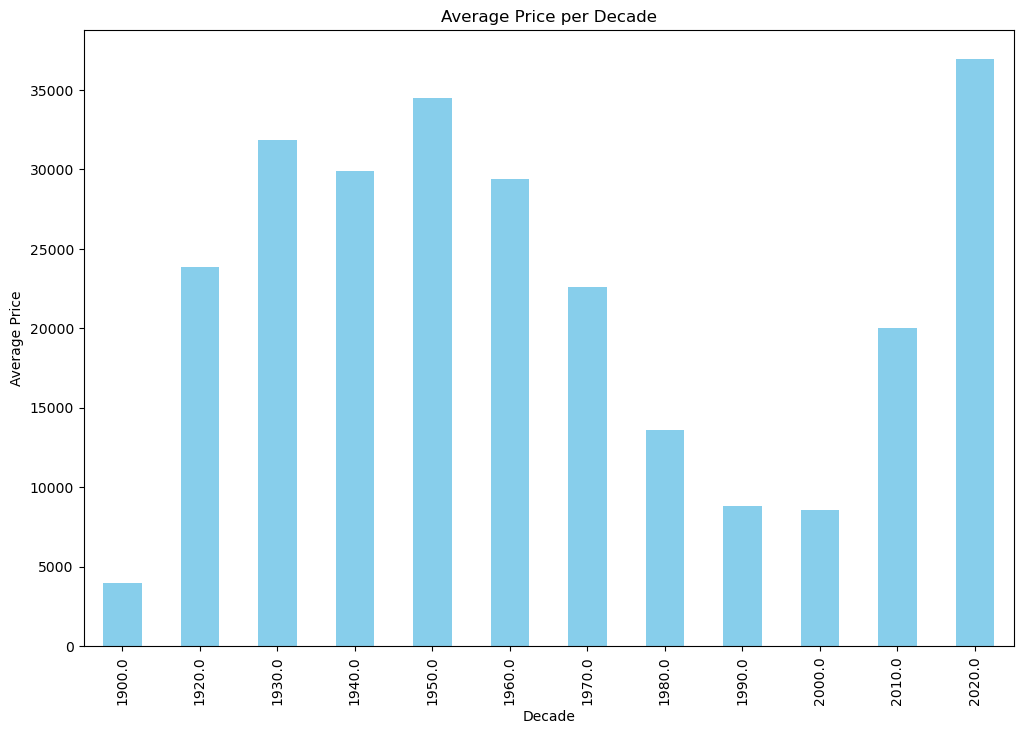

In [147]:
df_cleaned['decade'] = (df_cleaned['year'] // 10) * 10
average_price_per_decade = df_cleaned.groupby('decade')['price'].mean().sort_index()

plt.figure(figsize=(12, 8))
average_price_per_decade.plot(kind='bar', color='skyblue')
plt.xlabel('Decade')
plt.ylabel('Average Price')
plt.title('Average Price per Decade')
plt.show()


Finally, the year of the car is worth considering. It would appear that the newest cars sell for the highest price, with a sharp drop in price between the '80s and 2010s. However, there does seem to be some correlation in the price of "classic" cars from the 50's and 60's, according to the data!